# Plot joint deterministic inversion for shear modulus structure variations and fault slip

This notebook plots the results of a joint adjoint-based deterministic inversion of synthetic 2D surface geodetic data (e.g. GNSS sensors or InSAR) for the variation in the heterogeneous material structure and coseismic slip distribution.


In [3]:
# Import libraries
import dolfin as dl
import ufl
import math
import numpy as np
import pandas as pd
# Import libraries for plotting
from cmcrameri import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as tri
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=16)
rc('legend', fontsize=16)
TINY_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

import sys, os
#sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "...") )
import hippylib as hp
# Load TV regularization class, observation operator, and IO .xdmf
from pointwiseStateObs import PointwiseStateObservation
from TVprior_Joint import *
from FunctionsIO import FunctionsIO

# Define folders directory 
meshpath = "../mesh/"
loadpath = "./results_Joint_mu_nu/"
# Size domain
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Degree 
k = 2
# Define sep
sep = "\n"+"#"*80+"\n"


In [26]:
# Define function to plot the results
def plot_results(mesh, Vh, xf, yf, mu_true, m_mu, s_true, m_s, u, levels_m, savefigs=False):
    # Convert solution for plotting
    triang = tri.Triangulation(*mesh.coordinates().reshape((-1, 2)).T, triangles=mesh.cells())
    mu_m_true = mu_true.compute_vertex_values(mesh)
    mu_m = m_mu.compute_vertex_values(mesh)
    
    # Plot figure    
    fig = plt.figure(figsize=(14,9))
    x_text, y_text = -180, -120 
    props1 = dict(boxstyle='round', facecolor=cmap_1(0.7), edgecolor=cmap_1(0.7), alpha=1.)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.plot([lef, rig], [0.0, 0.0], 'k', linewidth=1.0)
    CS = ax.tricontourf(triang, (mu_m_true-np.mean(mu_m_true))/GPa2Pa, levels=levels_m, cmap=cmap_1, extend='both')
    pl = dl.plot(u, cmap=cmap_2, zorder=3)
    ax.plot(targets[:,0], targets[:,1]+2.5, marker="^", linestyle='None',           
            markersize=12, markerfacecolor="grey", markeredgecolor="black", zorder=1)
    ax.plot(xf, yf, color="black")
    ax.set_xlim((lef, rig))
    ax.set_ylim((bot, 10.0))
    ax.text(0.957, 0.975, r'\textbf{(a)}', transform=ax.transAxes, fontsize=16,
                            verticalalignment='top', bbox=props)
    ax.text(0.85, 0.85, r"true $\mathbf{m}_{\mu}$", transform=ax.transAxes, fontsize=SMALL_SIZE,
                            verticalalignment='top', bbox=props1)

    # Make a new Axes instance [left, bottom, width, height]
    axins = ax.inset_axes([-0.1, -0.5, 1, 1.1])
    axins.set_aspect('equal')
    axins.tricontourf(triang, (mu_m-np.mean(mu_m))/GPa2Pa, levels=levels_m, cmap=cmap_1, extend='both')
    axins.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
    axins.plot(xf, yf, color="black")
    axins.tick_params(axis='both', which='major')
    axins.set_xlim((lef, rig))
    axins.set_ylim((bot, topp))
    axins.set_ylabel("Depth [km]")
    axins.set_xlabel("Length [km]")
    axins.text(-0.085, -0.36, r'\textbf{(b)}', transform=ax.transAxes, fontsize=16,
                            verticalalignment='top', bbox=props) 
    axins.text(0.7, 0.4, r"recovered $\mathbf{m}_{\mu}$", transform=ax.transAxes, fontsize=SMALL_SIZE,
                            verticalalignment='top')

    # Make a new Axes instance [left, bottom, width, height]
    nseg_fault = len(yf)
    L = np.sqrt(yf[0]**2 + xf[0]**2) 
    width = np.linspace(0, L, nseg_fault) 

    axins2 = ax.inset_axes([0.285, -0.29, 0.6, 0.45])

    axins2.plot(width, np.zeros(len(width)), '-.', color="grey")
    axins2.plot(width, s_true, color="gray", linestyle='solid', linewidth=2.,
               label=r'$\mathbf{m}^{\mathrm{true}}_{s}$')
    axins2.plot(width, m_s, color="black", linestyle='dashed', linewidth=2., 
                label=r'$\mathbf{m}^{\mathrm{est}}_{s}$')
    axins2.legend(loc='lower left')
    axins2.set_xlim(( width.min(), width.max() ))
    axins2.set_ylim(( -10.5, 1. ))
    axins2.set_xlabel("Distance along the fault [km]")
    axins2.set_ylabel("Fault slip [m]")
    axins2.tick_params(axis='both', which='both')
    axins2.invert_xaxis()
    axins2.text(0.845, -0.23, r'\textbf{(c)}', transform=ax.transAxes, fontsize=16,
                            verticalalignment='top', bbox=props)
    axins2.text(0.575, 0.1, r"recovered $\mathbf{m}_{s}$", transform=ax.transAxes, fontsize=SMALL_SIZE,
                            verticalalignment='top')

    # Make a new Axes instance [left, bottom, width, height]
    cbar_ax = plt.gcf().add_axes([0.96, 0.25, 0.0125, 0.5])
    cbar = plt.colorbar( CS, cax=cbar_ax, orientation="vertical", 
                        ticks=[-5., -2.5, 0., 2.5, 5.],
                        format="%.1f")
    cbar.ax.set_yticklabels( ['-5', '-2.5', '0', '2.5', '5'] )
    cbar.set_label(r'[GPa]', labelpad=-15, y=1.1, rotation=0)
    plt.gcf().text(0.93, 0.2, r'$\Delta\mu(\mathbf{m}^{\mathrm{est}}_{\mu})$', fontsize=SMALL_SIZE)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')
    # Put second colorbar
    cbar_ax2 = plt.gcf().add_axes([0.96, 0.25, 0.0125, 0.5])
    # Scale colorbar
    scaling = (5/mu_true_background)*100
    scaling_ticks_ = np.array([-12, -6, 0., 6, 12])    
    scaling_ticks = (5*scaling_ticks_/scaling).tolist()
    cbar2 = plt.colorbar(CS, cax=cbar_ax2, ticks=scaling_ticks)
    cbar2.ax.set_yticklabels( ['-12', '-6', '0', '6', '12'] )
    cbar2.set_label(r'[\%]', labelpad=-20, y=1.17, rotation=0)

    # Make a new Axes instance [left, bottom, width, height]
    cbar_ax1 = plt.gcf().add_axes([0.855, 0.21, 0.0125, 0.25])
    cbar1 = plt.colorbar(pl, cax=cbar_ax1, orientation="vertical", extend='max',
                         ticks=[0., 1., 2., 3., 4., 5.], format="%.1f")
    cbar1.ax.set_yticklabels( ['0', '1', '2', '3', '4', '5'] )
    cbar1.ax.set_title(r'$|\mathbf{u}|$ [m]')
    cbar1.ax.xaxis.set_ticks_position('bottom')
    cbar1.ax.xaxis.set_label_position('bottom')

    plt.show()
    

In [5]:
# Define a function to retrieve the function spaces for plotting
def FunctionSpaces(mesh, k, verbose=True):
    # Define function spaces
    # Use VectorFunctionSpace if the unknown is a vector field.
    # Use FunctionSpace object for scalar fields.
    BDM = dl.VectorFunctionSpace(mesh, "BDM", k)    # stress (tensor field, since BDM is a vector field)
    DGv = dl.VectorFunctionSpace(mesh, "DG", k-1)   # displacement (vector field)
    DGr = dl.FunctionSpace(mesh, "DG", k-1)         # rotation (scalar field)
    ME_element = dl.MixedElement([BDM.ufl_element(), DGv.ufl_element(), DGr.ufl_element()])
    Vu = dl.FunctionSpace(mesh, ME_element)
    n = dl.FacetNormal(mesh)
    # Define mixed function spaces for the model parameters
    CG = dl.FunctionSpace(mesh, "CG", 1)
    CG_element = dl.MixedElement([CG.ufl_element(), CG.ufl_element()])
    Vm = dl.FunctionSpace(mesh, CG_element)
    # Combine the STATE, PARAMETER and ADJOINT function spaces
    Vh = [Vu, Vm, Vu]
    # Print the dofs of STATE, PARAMETER and ADJOINT variables
    ndofs = [ Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim() ]
    ndofs_state = [ Vu.sub(0).dim(), Vu.sub(1).dim(), Vu.sub(2).dim() ]
    if verbose:
        print( sep, "Set up the mesh and finite element spaces", sep )
        print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs) )
        print( "Number of STATE and ADJOINT dofs: STRESS={0}, DISPLACEMENT={1}, ROTATION={2}".format(*ndofs_state) )

        
    return Vh, CG, DGv
    

In [6]:
# Define the axes range
lef, rig, topp, bot = -200., 100., 0., -150.
GPa2Pa = 1e9

# Generate random surface observations
ntargets = 20
targets_x = np.linspace(-180., 0., ntargets) 
targets_y = (ymax-dl.DOLFIN_EPS)*np.ones(ntargets)
targets = np.zeros([ntargets, 2])
targets[:,0] = targets_x; targets[:,1] = targets_y

# Define colormaps and level for contourf
cmap_1 = plt.get_cmap("Oranges_r")
cmap_2 = plt.get_cmap("viridis", 21)
cmap_3 = plt.get_cmap("RdBu_r")
cmap_4 = plt.get_cmap("RdBu_r", 21)
levels_ux = np.linspace(-4., 4., 21)
levels_uy = np.linspace(-4., 4., 21)
levels_m = np.linspace(-5., 5., 21)
colors = [ cmap_1(0.3), cmap_1(0.6), cmap_1(0.9) ]

# Define the triangular perimeter of the anomaly
xy_triangle = np.array([ [-160.0,-5.0], [-30.0,-5.0], [-95.0, -55.0] ]) 

# For labels of subplots (a,b,c,d)
props = dict(boxstyle='round', lw=0.25, facecolor='ivory', alpha=0.95)

# Define the shear modulus background structure and the anomaly
mu_true_anomaly, mu_true_background = 26.49, 39.52


## Import finite-element mesh

In [7]:
# Import mesh
path = "../mesh/"
name = "Mesh_CurvedFault_Triangle_PaperII" 
mesh = dl.Mesh(path + name + '.xml')
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Extract dimension of the mesh
dim = mesh.topology().dim()
# Define normal component to boundaries
n = dl.FacetNormal(mesh)
# Define boundaries
boundaries = dl.MeshFunction("size_t", mesh, path + name + '_facet_region.xml')
subdomains = dl.MeshFunction("size_t", mesh, path + name + '_physical_region.xml')
top = 1
left = 2
bottom = 3
right = 4
fault = 5
blockleft = 7
blockright = 8
triangle = 9
triangle_surface = 10
ds = dl.Measure('ds')(domain=mesh, subdomain_data=boundaries)
dS = dl.Measure('dS')(domain=mesh, subdomain_data=boundaries)

# Define function space
Vh, CG, DGv = FunctionSpaces(mesh, k, verbose=True)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=57681, PARAMETER=2492, ADJOINT=57681
Number of STATE and ADJOINT dofs: STRESS=36162, DISPLACEMENT=14346, ROTATION=7173


## Load the joint inversion results from file

In [8]:
# Load results from .txt and .xdmf files
# Fault
filename = 'fault_geometry.txt'
fault = pd.read_csv(loadpath + filename, delimiter=' ')
xf, yf = fault['xf'], fault['yf']

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh.mpi_comm(), loadpath + filename, CG, function_names)
mu_true = all_funs[0]
m_mu = all_funs[1]

# Slip
filename = 'm_s.txt'
slip = pd.read_csv(loadpath + filename, delimiter=' ')
s_true, m_s = slip['true'], slip['cal']

# Displacements
filename = 'u'
u = dl.Function(DGv)
with dl.XDMFFile(mesh.mpi_comm(), loadpath + filename + ".xdmf") as fid:
        fid.read_checkpoint(u, 'u')


## Plot results

17.524054137122246 33.40006079435991


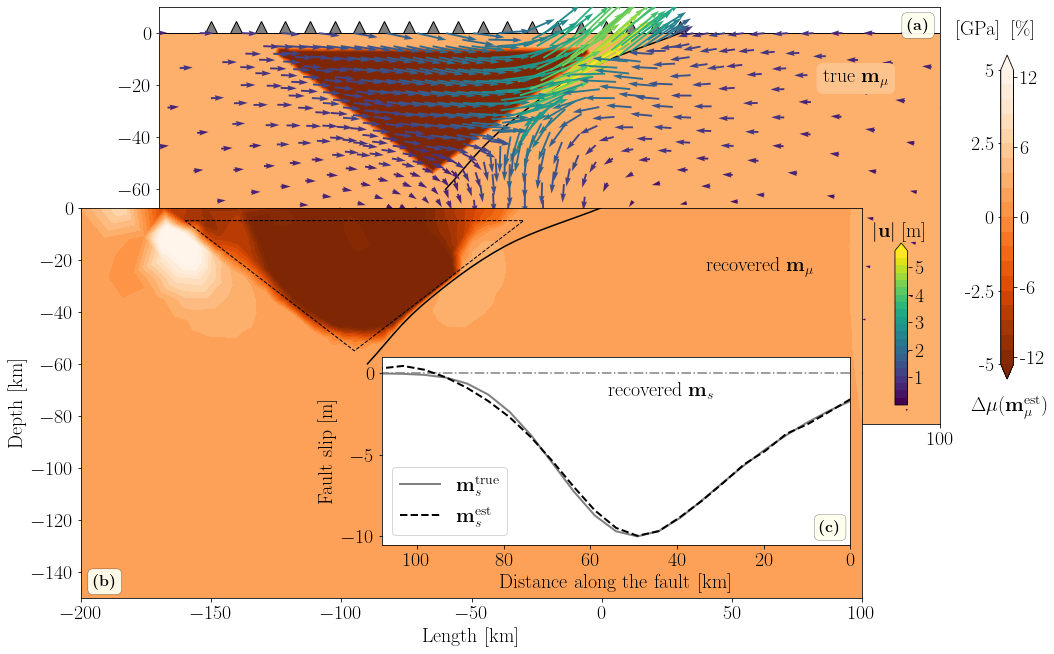

In [28]:
# Plot the solution
print( min(m_mu.vector()[:]/GPa2Pa), max(m_mu.vector()[:]/GPa2Pa) )

savefigs = True
plot_results(mesh, Vh, xf, yf, mu_true, m_mu, s_true, m_s, u, levels_m, savefigs=savefigs)
